<a href="https://colab.research.google.com/github/Appendme/big_data_analysis/blob/master/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install csvkit

In [ ]:
import sqlite3 as sql, re, pandas as pd
from matplotlib import pyplot as plt

In [ ]:
!csvsql --db sqlite:///internet_speed.db --insert samples/LA_wifi_speed_UK.csv samples/LA_population.csv

In [ ]:
con = sql.connect('internet_speed.db')
cur = con.cursor()

In [ ]:
query_date = 'SELECT Datetime FROM LA_wifi_speed_UK ORDER BY RANDOM() LIMIT 10'

for row in cur.execute(query_date):
    print(row)

('2016-12-05 15:00:00.000000',)
('2016-12-06 12:30:00.000000',)
('2016-12-10 05:30:00.000000',)
('2016-12-09 18:00:00.000000',)
('2016-11-27 11:00:00.000000',)
('2016-11-27 09:00:00.000000',)
('2016-12-12 15:30:00.000000',)
('2016-12-01 01:00:00.000000',)
('2016-12-05 20:30:00.000000',)
('2016-12-03 18:00:00.000000',)


In [ ]:
query_desc = 'SELECT * FROM LA_wifi_speed_UK LIMIT 1'
col = [n[0] for n in cur.execute(query_desc).description]
col = col[1:]
col = [re.sub(r'_\w', '', c) for c in col]
col = list(set(col))
col.remove('DateTime')

Text(0.5, 1.0, 'E08000023')

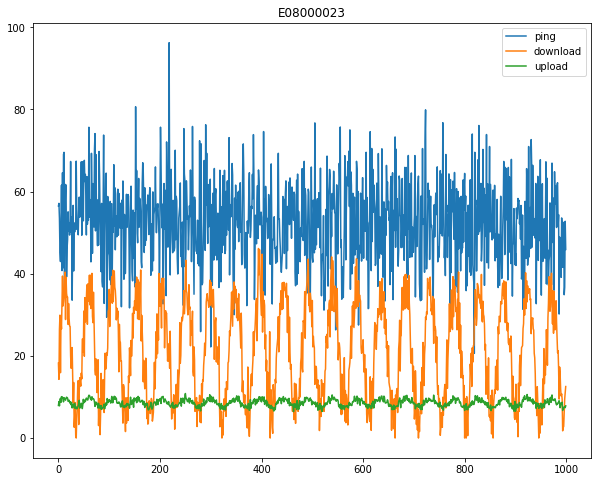

In [ ]:
plt.figure(figsize = (10, 8))
suffix = {'_p':'ping', '_d':'download', '_u':'upload'}

for (k, v) in suffix.items():
    cur.execute(f'SELECT {col[0]}{k} FROM LA_wifi_speed_UK ORDER BY DateTime')
    plt.plot(cur.fetchall(), label = v)

plt.legend()
plt.title(col[0])

In [ ]:
df = pd.DataFrame(columns = ['Area', 'Average_p', 'Average_d', 'Average_u'])
for c in col:
    l = [c]
    for (k, v) in suffix.items():
        cur.execute(f'SELECT AVG({c + k}) FROM LA_wifi_speed_UK')
        l.append(cur.fetchone()[0])

    df = df.append(pd.Series(l, df.columns), ignore_index = True)

df.head()

,Area,Average_p,Average_d,Average_u
0,E08000023,52.531300,21.366625,8.548282
1,E09000032,55.962499,22.859003,9.144285
2,E06000002,52.955802,21.137764,8.506712
3,E08000024,55.637342,22.680261,9.026876
4,E07000208,51.352087,20.927549,8.279380


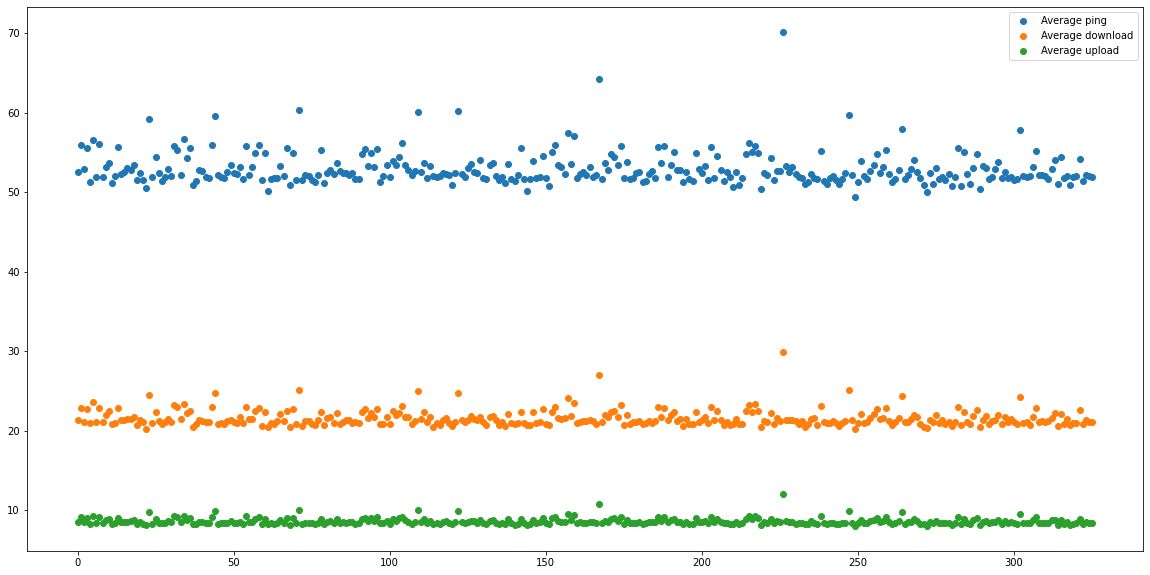

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(df.index, df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])

In [ ]:
try:
    cur.execute('DROP TABLE average_speed')
except:
    pass

df.to_sql('average_speed', con)

In [ ]:
for r in cur.execute('SELECT * FROM average_speed').fetchmany(4):
    print(r)

(0, 'E08000023', 52.53130022946711, 21.36662513821656, 8.548282096961298)
(1, 'E09000032', 55.96249889714122, 22.85900340588991, 9.144284919048276)
(2, 'E06000002', 52.95580230700414, 21.13776429335215, 8.50671227816365)
(3, 'E08000024', 55.63734165186476, 22.68026091645907, 9.026875624031291)


In [ ]:
cur.execute('SELECT * FROM average_speed JOIN LA_population ON average_speed.Area = LA_population.LA_code')
for r in cur.fetchmany(4):
    print(r)

(0, 'E08000023', 52.53130022946711, 21.36662513821656, 8.548282096961298, 'South Tyneside', 'E08000023', 148127.0)
(1, 'E09000032', 55.96249889714122, 22.85900340588991, 9.144284919048276, 'Wandsworth', 'E09000032', 306995.0)
(2, 'E06000002', 52.95580230700414, 21.13776429335215, 8.50671227816365, 'Middlesbrough', 'E06000002', 138412.0)
(3, 'E08000024', 55.63734165186476, 22.68026091645907, 9.026875624031291, 'Sunderland', 'E08000024', 275506.0)


In [ ]:
query = 'SELECT Area, Average_p, Average_d, Average_u, Total_Population FROM average_speed JOIN LA_population ON average_speed.Area = LA_population.LA_code'
cur.execute(query)

df = pd.DataFrame(columns = ['Area', 'Average_p', 'Average_d', 'Average_u', 'Population'])
for c in cur.fetchall():
    df = df.append(pd.Series(c, df.columns), ignore_index = True)

In [ ]:
sorted_asc = df.sort_values(['Population'])
sorted_asc.head()

,Area,Average_p,Average_d,Average_u,Population
272,E06000053,50.084966,20.358606,8.004334,2203.0
249,E09000001,49.384769,20.165312,8.047228,7375.0
22,E07000191,50.492327,20.280303,8.154217,34675.0
314,E06000017,50.992436,20.572656,8.153301,37369.0
219,E07000051,50.481485,20.484920,8.152685,44973.0


In [ ]:
sorted_dsc = df.sort_values(['Population'], ascending = False)
sorted_dsc.head()

,Area,Average_p,Average_d,Average_u,Population
226,E08000025,70.192955,29.853411,11.999448,1073045.0
167,E08000035,64.302549,26.995125,10.790424,751485.0
71,E08000019,60.352773,25.068847,10.052675,552698.0
247,E06000052,59.742131,25.161968,9.963647,532273.0
109,E08000032,60.068885,24.982134,9.982742,522452.0


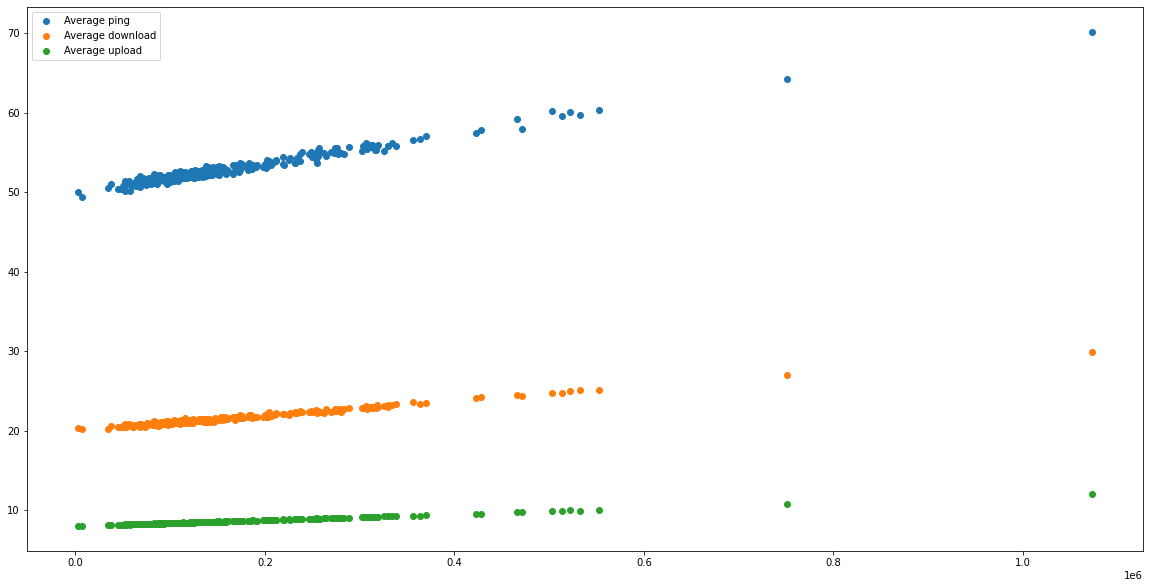

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(df['Population'], df[['Average_p', 'Average_d', 'Average_u']], 'o')
plt.legend(['Average ping', 'Average download', 'Average upload'])

# по графику ниже можно увидеть что средняя скорость не зависит от плотности населения, но при этом средняя задержка увеличивается

In [ ]:
print("Выполнил Коновалов С.В.")
print("Что такое csvsql, как она работает?")
print("Генерирует SQL запросы для создания баз данных.")
print("Можно ли объединить таблицы в базе данных, как это сделать?")
print("Да можно, с помощью SQL-JOIN")
print("Какой метод Pandas позволяет добавлять информацию в базу данных?")
print("Метод append")
print("Что делает метод fetchall ()?")
print("Возвращает список всех строк полученных при запросе к базе данных")
print("Почему для обработки данных используется библиотека Pandas, можно ли выполнить такую же обработку другим способом?")
print("Библиотека Pandas предназначена для обработки данный. Она иммеет в себе удобные методы и классы. Обработку можно сделать даже на голом Python, главное знание необходимых алгоритмов")